In [3]:
from core import download_IC
from core import download_ATNF

Data downloaded successfully


In [1]:
# from core import readfiles
import numpy as np
import os
import multiprocessing as mul
import matplotlib.pyplot as plt
from numba import jit, njit, prange, set_num_threads, vectorize, guvectorize, cuda
from tqdm import tqdm
from core.signal_bag import *
from core.stacking_analysis import *
from core.req_arrays import *
import pickle
import scipy.stats as st
import scipy.interpolate as interp
# import torch
# from core import weights

read icdata
read uptdata
read eadata
read mspdata


/home/darkwake/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:
num_threads = int(mul.cpu_count()*0.9)
set_num_threads(num_threads)

In [3]:
# UNCOMMENT FOR LINEAR BINS
# all_enu = np.linspace(10**11.001, 10**18.999, 1000)
all_enu = e_nu_wall

# enus = 0.5*(all_enu[1:]+all_enu[:-1])
# UNCOMMENT FOR DENSER LOGARITHMIC BINS, optimal nbins is 1e6
enus = np.logspace(11.001, 18.999, int(1e6))

In [4]:
enus_bin_indices = np.zeros(len(enus), dtype=np.int64)

for i in prange(len(enus)):
    enus_bin_indices[i] = np.digitize(enus[i], e_nu_wall) - 1

In [5]:
msdec_bin_indices = np.zeros(p, dtype=np.int64)
for i in prange(p):
    msdec_bin_indices[i] = np.digitize(msdec[i], dec_nu) - 1


In [6]:
gamma_arr = [-2, -2.2, -2.53, -3]
phio = np.logspace(-38, -26, 1000) #CHANGING TO LINEAR BINS RESULTS IN STRAIGHT LINES

# print("\nNumber of threads: ", num_threads)
print("\nNumber of energy bins: ", len(enus))
print("\nNumber of phi bins: ", len(phio))
print("\nCalculating weights...\n\n")


Number of energy bins:  1000000

Number of phi bins:  1000

Calculating weights...




In [7]:
eareaa = [i.astype(np.float64) for i in earea]

In [8]:
eareaa = np.asfarray(eareaa, dtype=np.float64)

In [9]:
eareaa[0][0]

0.0

In [10]:
earea2 = np.asfortranarray(earea)

In [11]:
earea2 = earea2[0].astype(np.float64)

In [12]:
@vectorize(['float64(int64, float64, int64)'], nopython=True, target='parallel')
def psr_wt_sing_gamma(psrno,gamma, season):

    tt_upt = t_upt[season]
    l = msdec_bin_indices[psrno]
    wt_ac_temp = np.zeros(len(enus), dtype=np.float64)
    for i in prange(len(enus)):
        wt_ac_temp[i] = np.float64(tt_upt * earea[ea_season(season)][l*40 + enus_bin_indices[i]] * enus[i]**gamma)


    return np.trapz(wt_ac_temp, enus)


wt_vec = psr_wt_sing_gamma(range(p), -1, 0)

In [13]:
w_models = np.column_stack([np.ones(p), 1/(msdist**2), mss1400]).T.astype(np.float64)
sum_wt_model = [1, np.sum(1/(msdist**2)), np.sum(mss1400)]

In [14]:
altier_path = [os.getcwd() + '/pickle/', os.getcwd() + '/../pickle/']
if f'wt_acc_{len(enus)}_bins.pkl' in os.listdir(altier_path[0]):# or f'wt_acc.pkl_{len(enus)}' in os.listdir(altier_path[1]):
    print("Loading wt_acc from pickle")
    # try:
    #     wt_acc = pickle.load(altier_path[1] + f'wt_acc.pkl_{len(enus)//2}_bins')
    # except:
    with open(altier_path[0] + f'wt_acc_{len(enus)}_bins.pkl', 'rb') as f:
        wt_acc = pickle.load(f)
    
    
    print("Loaded wt_acc from pickle with nbins= ", len(enus))

else:
    print("Calculating wt_acc for all pulsars and seasons and gamma")
    wt_acc = []
    for gamma in prange(len(gamma_arr)):
        wt_allpsr = []
        for season in tqdm(prange(10)):
            # tmp = []
            # for psrno in prange(p):
                # w_model = w_models[psrno]
                # tmp.append(psr_wt_sing_gamma(psrno, gamma_arr[gamma], season))
                # tmp.append(trapz_numba(psr_wt_sing_e_gamma(psrno, enus, gamma_arr[gamma], season), enus))

            wt_allpsr.append(np.array(psr_wt_sing_gamma(prange(p), gamma_arr[gamma], season), dtype=np.float64))
            # tmp = []
        wt_acc.append(wt_allpsr)
        wt_allpsr = []
        
    wt_acc = np.asfarray(wt_acc, dtype=np.float64)
    with open(altier_path[0] + f'wt_acc_{len(enus)}_bins.pkl', 'wb') as f:
        pickle.dump(wt_acc, f)
    print("Calculated wt_acc for all pulsars and seasons and gamma")

Calculating wt_acc for all pulsars and seasons and gamma


100%|██████████| 10/10 [02:39<00:00, 15.99s/it]

Calculated wt_acc for all pulsars and seasons and gamma


In [15]:
season_walls = np.asarray([0, 36900, 143911, 237044, 373288, 486146, 608687, 735732, 865043, 988700, 1134450])
season_widts= np.diff(season_walls)

In [16]:
#Compute the signal PDF for all neutrinos as per eqns 6, 7 and weights as per eqn 8 of 2205.15963

@njit(nogil=True)
def S_ijk(nu): 

    '''
    Calculates S_ij as in EQN 7 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino in the sample
        
    
    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
    '''
    ang2 = hvovec(msra, msdec, icra[nu], icdec[nu], rad=True) ** 2      #rad**2
    sg = np.deg2rad(icang[nu]) ** 2                                     #rad**2
    return np.divide(np.exp(-1 * np.divide(ang2, 2*sg)), (2 * np.pi * sg))      #1/rad**2


@njit(nogil=True)
def S_ik(nu, weight, w_models, gamma_index, ws):

    '''
    
    Calculates S_i as in EQN 8 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino in the sample

    normalized_wt : array
        Normalized weights of the pulsars


    gamma_index : int
        Index of the gamma value in the gamma array

    ws : int
        Index of the weight model

    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino

    '''

    # si_sing_season_g =
    # for i in prange(p):
        # sij = S_ijk(nu)
        # np.sum(np.multiply(sij, normalized_wt[i][gamma_index][season]))      #1/rad**2



    sij = S_ijk(nu)
    season = 0
    for i in range(10):
        if season_walls[i] <= nu and nu < season_walls[i+1]:
            season = i
            break

    return np.sum(np.multiply(sij, np.multiply(w_models[ws], weight[gamma_index][season])/np.sum(np.multiply(w_models[ws], weight[gamma_index][season]))))      #1/rad**2


In [17]:
@njit(parallel=True, nogil=True)
def Sik_sing_s_g(gamma_index, ws):#, wt_acc=wt_acc, w_models=w_models):
    '''
    Calculates S_i as in EQN 8 of 2205.15963
    ----------

    Parameters
    ----------
    weight : array
         weights of the pulsars

    season : int
        Season of the neutrino

    gamma_index : int
        Index of the gamma value in the gamma array

    ws : int
        Index of the weight model

    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
    '''



    tmp = []
    if ws == -1: #No weights
        for nu in prange(len(icra)):
            tmp.append(np.sum(S_ijk(nu)))
        return np.array(tmp, dtype=np.float64)

    for nu in prange(len(icra)):
        tmp.append(S_ik(nu, wt_acc, w_models, gamma_index, ws))
    return np.array(tmp, dtype=np.float64)

In [18]:
#Pickle
if os.path.isfile(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins.pkl'):
    print("Loading all_Si_ws_g_s from pickle")
    with open(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins.pkl', 'rb') as f:
        all_Si_ws_g_s = pickle.load(f)
    print("Loaded all_Si_ws_g_s from pickle with nbins =", len(enus))
else:


    print("\nCalculating S_i for all neutrinos and gammas and weighting schemes...\n")

    all_Si_ws_g_s = []
    tmp = []
    tmp_wt_acc = []
    tmp_wt_acc_w_dist = []
    tmp_wt_acc_w_s1400 = []

    for gamma_index in tqdm(prange(4)):
        # for season in tqdm(prange(10)):
        tmp.append(Sik_sing_s_g(gamma_index, -1))
        tmp_wt_acc.append(Sik_sing_s_g(gamma_index, 0))
        tmp_wt_acc_w_dist.append(Sik_sing_s_g(gamma_index, 1))
        tmp_wt_acc_w_s1400.append(Sik_sing_s_g(gamma_index, 2))


    all_Si_ws_g_s.append([tmp, tmp_wt_acc, tmp_wt_acc_w_dist, tmp_wt_acc_w_s1400])
    tmp = []
    tmp_wt_acc = []
    tmp_wt_acc_w_dist = []
    tmp_wt_acc_w_s1400 = []
    all_Si_ws_g_s = np.asfarray(all_Si_ws_g_s[0])

    print("Calculated S_i for all neutrinos and gammas and weighting schemes")
    #Save to pickle
    with open(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins.pkl', 'wb') as f:
        pickle.dump(all_Si_ws_g_s, f)




Calculating S_i for all neutrinos and gammas and weighting schemes...



100%|██████████| 4/4 [03:27<00:00, 51.87s/it]


Calculated S_i for all neutrinos and gammas and weighting schemes


In [19]:
# @jit(nopython=True)
@vectorize(['float64(int64, int64)'], nopython=True,target='parallel')
def Bi_stacked_compute(nu, cone=5):

    '''
    Calculates B_i as in EQN 9 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino from IceCube sample
    cone : float
        Cone angle in degrees.
    

    Returns
    -------
    float
        Returns the background PDF for the {nu}th neutrino
    '''

    # count = np.sum(np.abs(np.subtract(icdec, icdec[nu])) <= cone)
    count=0
    for i in prange(len(icdec)):
        if abs(icdec[i] - icdec[nu]) <= cone:
            count+=1
    binwidth = (np.sin(np.deg2rad(icdec[nu] + cone)) - np.sin(np.deg2rad(icdec[nu] - cone)))*2*np.pi
    return count/(binwidth * N_ic)           #No units or sr**-1

In [20]:
#Pickle
if os.path.isfile(altier_path[0] + f'all_Bi.pkl'):
    print("Loading all_Bi from pickle...")
    with open(altier_path[0] + f'all_Bi.pkl', 'rb') as f:
        all_Bi = pickle.load(f)
    print("Loaded all_Bi from pickle")
else:
    print("\nCalculating Bi for all neutrinos\n")
    all_Bi = Bi_stacked_compute(np.arange(lnu), 5)
    # all_Bi+=1e-90
    print("\nCalculated Bi for all neutrinos")
    #Save to pickle
    with open(altier_path[0] + f'all_Bi.pkl', 'wb') as f:
        pickle.dump(all_Bi, f)


Calculating Bi for all neutrinos


Calculated Bi for all neutrinos


 '''
    This function returns the number of signal events for a single pulsar as in EQN3 of 2205.15963
    -------------------

    Parameters
    ----------
    dec : float
        The declination of the pulsar in radians
    
    enu : float
        The neutrino energy in eV

    gamma : float
        The spectral index of the neutrino flux

    phi0 : float (optional)
        The normalization constant of the neutrino flux

    season : int (optional)
        The IceCube season number
    
    Returns
    -------
    float
        The number of signal events for the given parameters
    '''


In [21]:
type(msdec_bin_indices[0])

numpy.int64

In [22]:
arr = np.zeros(10, dtype=np.float64)

In [23]:
#generates ns^ for a single pulsar a single season and a single energy


# @vectorize(['float64(int64, float64, int64)'], nopython=True, target='parallel')
# def psr_wt_sing_gamma(psrno,gamma, season):

#     tt_upt = t_upt[season]
#     l = msdec_bin_indices[psrno]
#     wt_ac_temp = np.zeros(len(enus), dtype=np.float64)
#     for i in prange(len(enus)):
#         wt_ac_temp[i] = np.float64(tt_upt * earea[ea_season(season)][l*40 + enus_bin_indices[i]] * enus[i]**gamma)


#     return np.trapz(wt_ac_temp, enus)
# @njit
# @vectorize(['float64(float64, float64, float64, int64)'], target='parallel')
@vectorize(['float64(int64, float64, float64, int64)'], nopython=True, target='parallel')
def ns_singleseason_sing_psr_HAT(psrno,gamma, phi0, season):
   

    tt_upt = t_upt[season]
    # if enu <= 1e11 or enu >= 1e19:
    #     return 0.0
    # else:
        # k=0
    l = msdec_bin_indices[psrno]
        # for i in range(0, len(e_nu_wall)):
        #     if e_nu_wall[i] <= enu and e_nu_wall[i+1] > enu:
        #         k=i
        #         break

        # for j in range(0, len(dec_nu)):
        #     if dec_nu[j] <= dec and dec_nu[j+1] > dec:
        #         l=j
        #         break
    ns_temp = np.zeros(len(enus), dtype=np.float64)
    for i in prange(len(enus)):
        ns_temp[i] += np.float64(tt_upt * earea[ea_season(season)][l*40 + enus_bin_indices[i]] * phi0 * (enus[i]/(10**14))**gamma)
    # temp_ea = np.asarray(earea[ea_season(season)])[l*40 + k]
    # return tt_upt * temp_ea * phi0 * ((enu/(10**14))**gamma)     #in s cm2 eV

    return np.trapz(ns_temp, enus)     #in s cm2 eV


In [24]:
def ns_HAT_all_season_all_psr_sing_gamma_wt_wtht_weights(gamma, e_nus=enus, phi0=1):
    ns_hat = 0
    ns_hat_wt = 0
    ns_hat_wt_dist = 0
    ns_hat_wt_s1400 = 0
    for season in tqdm(prange(10)):
        # for psr in prange(p):
            # wt = all_weights[0][gamma_arr.index(gamma)][psr][ea_season(season)]
        wt_sum = np.sum(wt_acc[gamma_arr.index(gamma)][season])

        wt = wt_acc[gamma_arr.index(gamma)][season]
        ns_hat = ns_singleseason_sing_psr_HAT(prange(p), gamma, phi0, season)
        # ns_hat_wt += np.dot(wt, nsop)
        # ns_hat_wt_dist += np.dot(wt/msdist[prange(p)]**2, nsop)
            # nsop = ns_singleseason_sing_psr_HAT(msdec[psr], e_nus, gamma, phi0, season)
            
            # ns_hat += np.trapz(nsop, x=e_nus)
        
    #         ns_hat_wt += wt * np.trapz(nsop, x=e_nus)
    #         ns_hat_wt_dist += wt * np.trapz(nsop, x=e_nus) / (msdist[psr]**2)
    #         ns_hat_wt_s1400 += wt * np.trapz(nsop, x=e_nus) * mss1400[psr]
    # return np.array([ns_hat, ns_hat_wt, ns_hat_wt_dist, ns_hat_wt_s1400], dtype=np.float64)

        ns_hat_wt += np.dot((wt/wt_sum),  ns_hat)
        ns_hat_wt_dist += np.dot(wt * w_models[1]/ np.sum(np.multiply(wt_acc[gamma_arr.index(gamma)][season], w_models[1])) , ns_hat)
        ns_hat_wt_s1400 += np.dot(wt * w_models[2]/ np.sum(np.multiply(wt_acc[gamma_arr.index(gamma)][season], w_models[2])), ns_hat)
    return np.array([np.sum(ns_hat), ns_hat_wt, ns_hat_wt_dist, ns_hat_wt_s1400], dtype=np.float64)

In [25]:
#Pickle
arr = []
if os.path.isfile(altier_path[0] + f'ns_all_ws_{len(enus)}_bins.pkl'):
    print("Loading ns_hat from pickle...")
    with open(altier_path[0] + f'ns_all_ws_{len(enus)}_bins.pkl', 'rb') as f:
        arr = pickle.load(f)
    print("Loaded ns_hat from pickle with nbins =", len(enus))
else:
    print("\nCalculating ns_HAT for all gamma and weighting schemes...\n")

    arr=[]
    for gamma in prange(len(gamma_arr)):
        tmp = ns_HAT_all_season_all_psr_sing_gamma_wt_wtht_weights(gamma_arr[gamma])
        np.savetxt('ns_hat_wt_wt_gamma_{}.txt'.format(gamma_arr[gamma]), tmp)
        arr.append(tmp)
        tmp = []

    arr = np.array(arr, dtype=np.float64)
    with open(altier_path[0] + f'ns_all_ws_{len(enus)}_bins.pkl', 'wb') as f:
        pickle.dump(arr, f)
    print("\nCalculationed ns_HAT for all gamma and weighting schemes")


Calculating ns_HAT for all gamma and weighting schemes...



100%|██████████| 10/10 [02:39<00:00, 15.92s/it]


Calculationed ns_HAT for all gamma and weighting schemes


In [26]:
arr.shape

(4, 4)

In [27]:
@njit(parallel=True, nogil=True)
def season_nu(nu):
    for i in prange(10):
        if nu >= season_walls[i] and nu < season_walls[i+1]:
            return i

t2mp = all_Si_ws_g_s[0][0]
nsa = 50
@njit(nogil=True)
def TS_for_all_psrs2(nsa):  
    return Ts_arr2(nsa, t2mp, all_Bi, Ns) 

TS_for_all_psrs2(nsa)

In [28]:
@jit(nopython=True)
def Pr(x, Ns, S, B):
    nsN = x/Ns
    return np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))



@njit(nogil=True)
def TS_st_vec(x, S, B, Ns):
    nsN = x/Ns
    pr = np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))
    return np.sum(np.asfarray(2*np.log(pr/B)))

lnu = 1134450
Ns = lnu#np.count_nonzero(nuind+1)


TS_st_vec(0.5e6, all_Si_ws_g_s[0][0], all_Bi, Ns)

In [29]:
phio = np.logspace(-38, -26, 1000)

In [30]:
print('\nCALCULATING TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS\n')

all_TSS = []
for ws in prange(4):
    tmpp = []
    print("ws = {}".format(ws))
    for gamma in prange(len(gamma_arr)):
        print("gamma = {}".format(gamma))
        # tmp = np.zeros(len(phio))
        # for season in tqdm(range(10)):
        t2mp = np.asfarray(all_Si_ws_g_s[ws][gamma])
        @njit(nogil=True)
        def TS_for_all_psrs2(nsa):  
            return TS_st_vec(nsa, t2mp, all_Bi, Ns)      #No units
        temp = []
        for phi in tqdm(prange(len(phio))):
            temp.append(TS_for_all_psrs2(arr[gamma][ws]*phio[phi]))
        tmpp.append(temp)
        temp = []
    all_TSS.append(tmpp)
    tmpp = []

print('\nCALCULATED TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS')


CALCULATING TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS

ws = 0
gamma = 0


100%|██████████| 1000/1000 [00:07<00:00, 126.18it/s]


gamma = 1


100%|██████████| 1000/1000 [00:07<00:00, 130.13it/s]


gamma = 2


100%|██████████| 1000/1000 [00:07<00:00, 131.78it/s]


gamma = 3


100%|██████████| 1000/1000 [00:08<00:00, 123.77it/s]


ws = 1
gamma = 0


100%|██████████| 1000/1000 [00:07<00:00, 138.88it/s]


gamma = 1


100%|██████████| 1000/1000 [00:07<00:00, 139.28it/s]


gamma = 2


100%|██████████| 1000/1000 [00:07<00:00, 137.87it/s]


gamma = 3


100%|██████████| 1000/1000 [00:07<00:00, 128.29it/s]


ws = 2
gamma = 0


100%|██████████| 1000/1000 [00:07<00:00, 131.85it/s]


gamma = 1


100%|██████████| 1000/1000 [00:07<00:00, 131.41it/s]


gamma = 2


100%|██████████| 1000/1000 [00:07<00:00, 139.00it/s]


gamma = 3


100%|██████████| 1000/1000 [00:07<00:00, 134.66it/s]


ws = 3
gamma = 0


100%|██████████| 1000/1000 [00:07<00:00, 131.55it/s]


gamma = 1


100%|██████████| 1000/1000 [00:07<00:00, 136.72it/s]


gamma = 2


100%|██████████| 1000/1000 [00:07<00:00, 138.94it/s]


gamma = 3


100%|██████████| 1000/1000 [00:07<00:00, 136.87it/s]


CALCULATED TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS


### $N \approx 10^6$

In [31]:
all_TSS = np.array(all_TSS, dtype=np.float64)
all_TSS.shape

(4, 4, 1000)

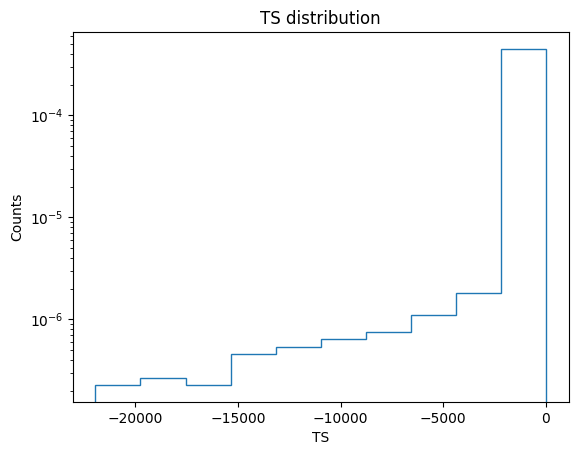

In [32]:
# for i in range(1, len(all_TSS)):
plt.figure()
histdetails = plt.hist(np.ravel(all_TSS[1:]), bins=10, density=True, histtype='step')
# plt.ylim(0, 1000)
plt.yscale('log')
plt.xlabel('TS')
plt.ylabel('Counts')
plt.title('TS distribution')
plt.show()

In [33]:
histdetails = np.histogram(np.ravel(all_TSS[1:]), bins=10)

In [34]:
histdetails

(array([    6,     7,     6,    12,    14,    17,    20,    29,    48,
        11841]),
 array([-2.19375432e+04, -1.97421780e+04, -1.75468128e+04, -1.53514476e+04,
        -1.31560824e+04, -1.09607172e+04, -8.76535197e+03, -6.56998677e+03,
        -4.37462157e+03, -2.17925637e+03,  1.61088283e+01]))

In [35]:
len(np.ravel(all_TSS[1:]))

12000

np.count_nonzero(np.ravel(all_TSS[1:])> )

In [37]:
all_TSS = np.array(all_TSS, dtype=np.float64)

In [38]:
all_TSS.shape

(4, 4, 1000)

In [39]:
for w in range(1,4):
    for g in range(len(gamma_arr)):
        print(min(all_TSS[w][g]), max(all_TSS[w][g]))
        # np.savetxt(f'TS_w{w}_g{g}.txt', all_TSS[w][g])
        
    print('wt\n')

with open(altier_path[0] + f'all_TSS_{len(enus)}_bins.pkl', 'wb') as f:
    pickle.dump(all_TSS, f)

-63.668731237900175 12.159433069810351
-120.9668681421757 14.842381426589782
-749.3953613344512 16.108828296203917
-15074.617735496455 15.97998363261133
wt

-290.39043040963213 1.2954848848763725
-447.34353393746517 3.177930872514708
-1791.739816646375 4.667533386198258
-21937.543169959703 4.902201365084016
wt

-184.98856651799082 4.653289913284717
-326.2472224620502 6.824264424911556
-1543.3075342794907 7.382929219484599
-21524.981198784375 7.272246912132048
wt



In [40]:
#Plotting

all_TSS = np.asarray(all_TSS)
gamma_arr = np.asarray(gamma_arr)

all_e_UL = []
e_decade = [1e13, 1e14, 1e15, 1e16, 1e17]
for e_UL in e_decade:
    e2dfde = []

    for gamma in prange(len(gamma_arr)):
        temp = []
        for phi in range(len(phio)):
            temp.append( e_UL**2 * dfde(e_UL, gamma_arr[gamma], phio[phi]))        #in eV
        e2dfde.append(temp)
    e2dfde = np.asarray(e2dfde)

    all_e_UL.append(e2dfde)
mark = ['^', 'o', 's', 'd']

In [41]:
all_TSS[1][2].shape

(1000,)

In [42]:
#Gamma = -2.5
#ws = 1/dist**2
e2dfde = all_e_UL[1][2]
dist_g25 = interp.interp1d(all_TSS[1][2], e2dfde/1e9)

print(dist_g25(-3.84))

all_UL = []
for ws in range(1,4):
    ul_all_gamma = []
    for gamma in prange(len(gamma_arr)):
        temp = []
        for i in all_e_UL:
            dist_g = interp.interp1d(all_TSS[ws][gamma], i[gamma]/1e9)
            temp.append(dist_g(-3.84))

        ul_all_gamma.append(temp)
    all_UL.append(ul_all_gamma)

2.41025285081015e-08


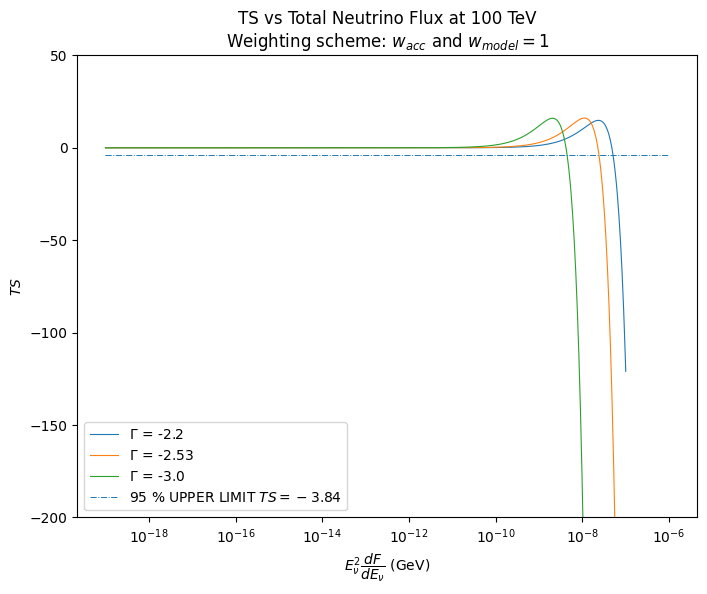

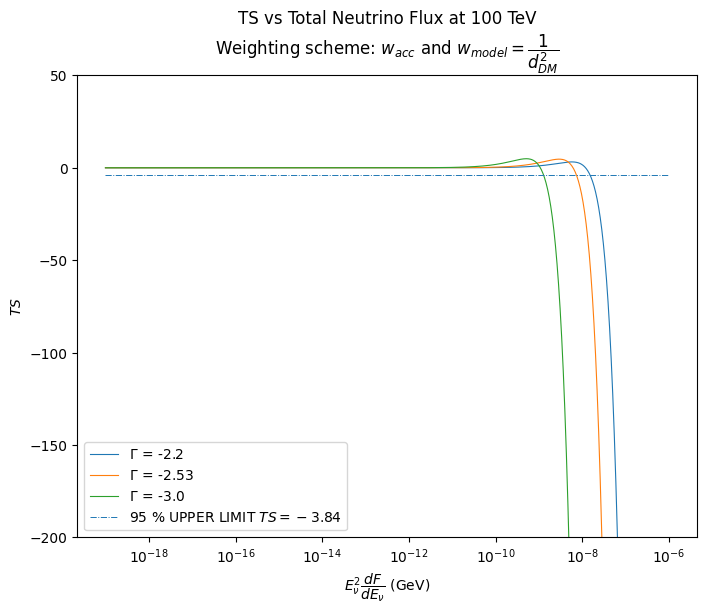

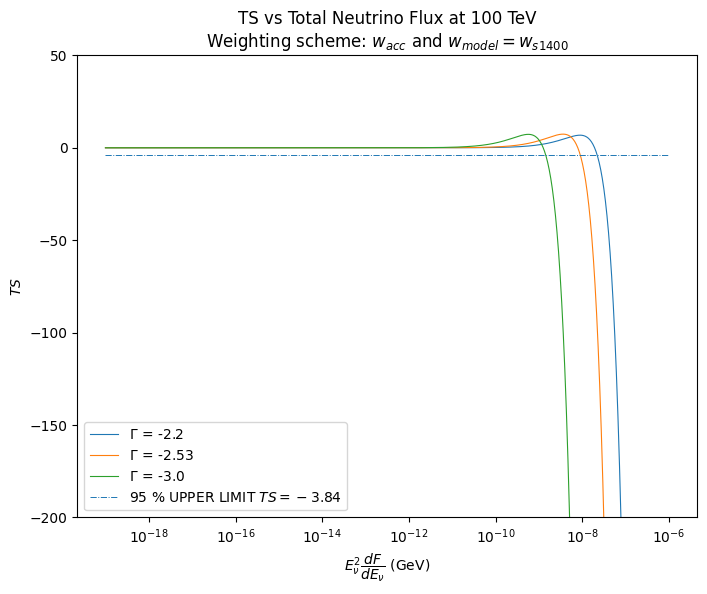

In [44]:
e2dfde = all_e_UL[1]
plttitles = ['$w_{acc}$ and $w_{model} = 1$', '$w_{acc}$ and $w_{model} = \dfrac{1}{d_{DM}^2}$', '$w_{acc}$ and $w_{model} =  w_{s1400}$']

        # print(st.t.interval(0.95, len(all_TSS[i][j])-1, loc=np.mean(all_TSS[i][j]), scale=st.sem(all_TSS[i][j])))
for i in range(1, 4):
    plt.figure(figsize=(8, 6))
    for j in range(1, len(gamma_arr)):
        plt.plot(e2dfde[j]/1e9, all_TSS[i][j], label='$\Gamma$ = ' + str(gamma_arr[j]), lw=0.8)
        # ci = st.t.interval(0.95, len(all_TSS[i][j])-1, loc=np.mean(all_TSS[i][j]), scale=st.sem(all_TSS[i][j]))
        # plt.hlines(ci, 1e-19, 1e-6, colors='k', linestyles='dashed', lw=0.5, ls='-.', label="95% CI "+ '$\Gamma$ = ' + str(gamma_arr[j]))

    plt.hlines(-3.84, 1e-19, 1e-6, linestyles='dashed', lw=0.7, ls='-.', label='95 % UPPER LIMIT $TS = -3.84$')
    # plt.vlines(dist_g25(-3.84), -120, 50, linestyles='dashed', lw=0.5, ls='-.')
    plt.legend()
    plt.xscale('log')
    # plt.yscale('log')
    plt.xlabel("$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ (GeV)")
    plt.ylabel(r'$TS$')
    plt.ylim(-200, 50)
    plt.title("TS vs Total Neutrino Flux at 100 TeV\nWeighting scheme: " + plttitles[i-1])
    plt.savefig(os.getcwd() + f'/outputs/TSvsE2dFdE_ws_{i}.png', facecolor='w')
    plt.show()

In [45]:
def dfde_ul(enu, gamma, phi, flux=1e14):
    return phi * (enu/flux)**gamma

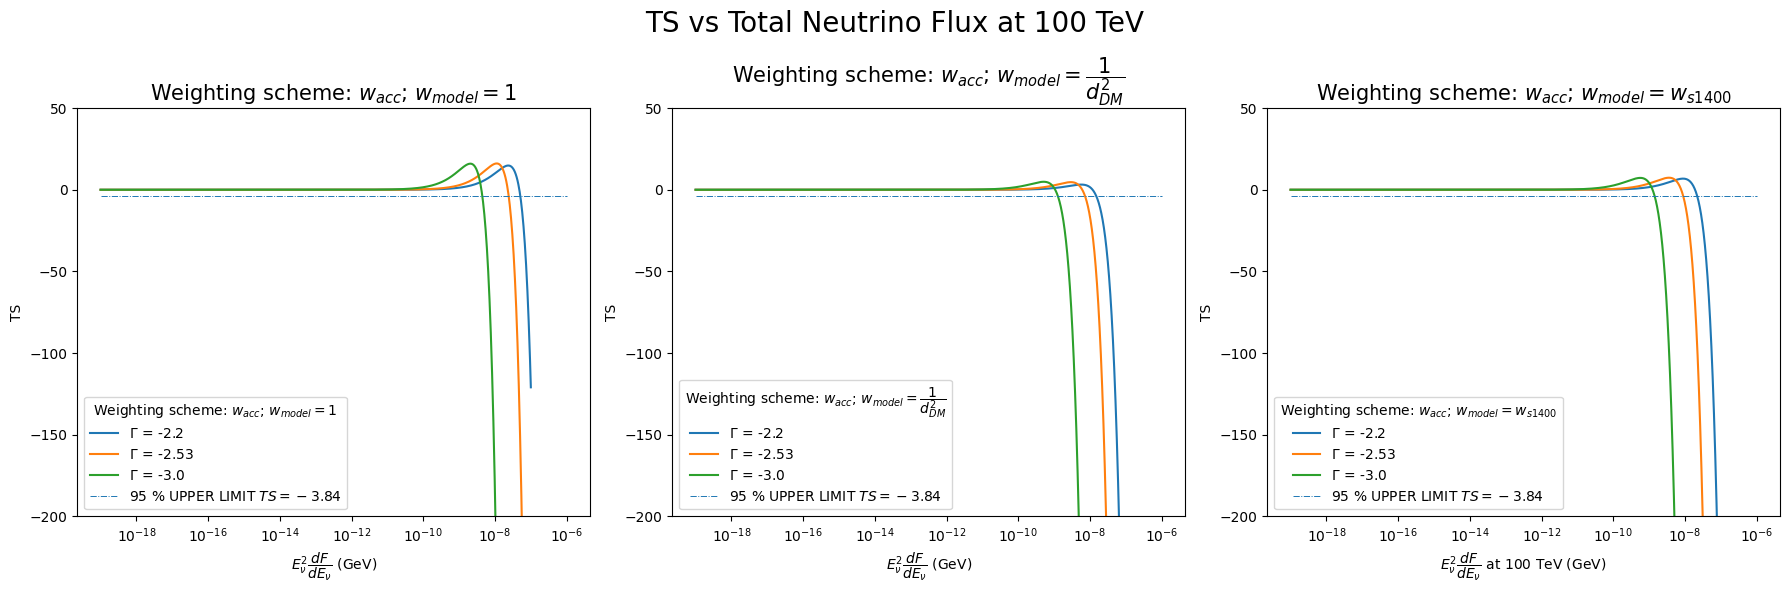


TS_vs_E2dfde_all_w_model_bins=1000000.png
DONE


In [46]:
plt.style.use('default')
fig, axs = plt.subplots(1,3, figsize=(18, 6))

for gamma in [ 1, 2, 3]:#range(4):
    # axs[0,0].plot(e2dfde[gamma]/1e9, all_TSS[0][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]))    #in GeV

    axs[0].plot(e2dfde[gamma]/1e9, all_TSS[1][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]))# + ' with wt')    #in GeV

    axs[1].plot(e2dfde[gamma]/1e9, all_TSS[2][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]))# + ' with wt and dist')    #in GeV

    axs[2].plot(e2dfde[gamma]/1e9, all_TSS[3][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]))# + ' with wt and s1400')    #in GeV

axs[0].set_title('Weighting scheme: $w_{acc}$; $w_{model} = 1$', fontsize=15)
axs[1].set_title('Weighting scheme: $w_{acc}$; $w_{model} = \dfrac{1}{d_{DM}^2}$' , fontsize=15)
axs[2].set_title('Weighting scheme: $w_{acc}$; $w_{model} = w_{s1400}$', fontsize=15)




axs[0].hlines(-3.84, 1e-19, 1e-6, linestyles='dashed', lw=0.7, ls='-.', label='95 % UPPER LIMIT $TS = -3.84$')
axs[1].hlines(-3.84, 1e-19, 1e-6, linestyles='dashed', lw=0.7, ls='-.', label='95 % UPPER LIMIT $TS = -3.84$')
axs[2].hlines(-3.84, 1e-19, 1e-6, linestyles='dashed', lw=0.7, ls='-.', label='95 % UPPER LIMIT $TS = -3.84$')

axs[0].legend(title = 'Weighting scheme: $w_{acc}$; $w_{model} = 1$')
axs[0].set_xscale('log')
axs[0].set_xlabel('$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ (GeV)')
axs[0].set_ylabel('TS')
# axs[0].set_title('TS vs $E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$')
axs[0].set_ylim(-200, 50)

axs[1].legend(title = 'Weighting scheme: $w_{acc}$; $w_{model} =\dfrac{1}{d_{DM}^2}$')
axs[1].set_xscale('log')
axs[1].set_xlabel('$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ (GeV)')
axs[1].set_ylabel('TS')
# axs[1].set_title('TS vs $E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$')
axs[1].set_ylim(-200, 50)

axs[2].legend(title = 'Weighting scheme: $w_{acc}$; $w_{model} = w_{s1400}$')
axs[2].set_xscale('log')
axs[2].set_xlabel('$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ at 100 TeV (GeV)')
axs[2].set_ylabel('TS')
# axs[2].set_title('TS vs $E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$')
axs[2].set_ylim(-200, 50)


plt.suptitle('TS vs Total Neutrino Flux at 100 TeV', fontsize=20)
plt.tight_layout()
plt.savefig(f'TS_vs_E2dfde_all_w_model_bins={len(enus)}.png')
plt.show()
print(f'\nTS_vs_E2dfde_all_w_model_bins={len(enus)}.png\nDONE')

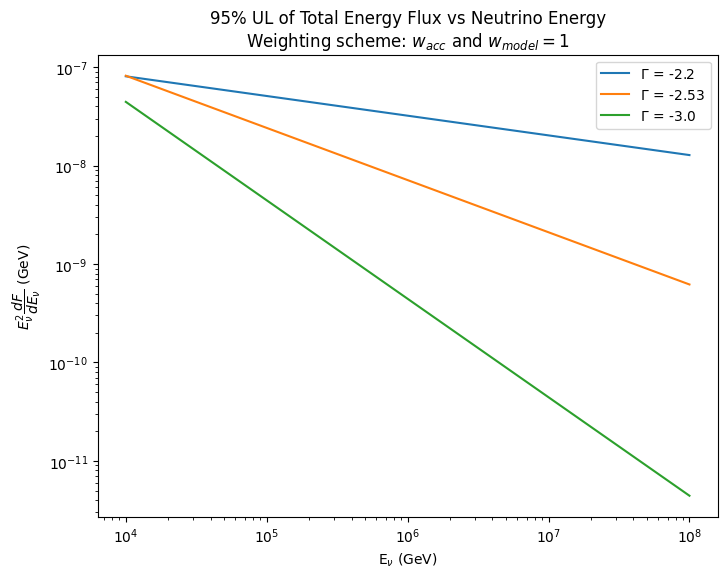

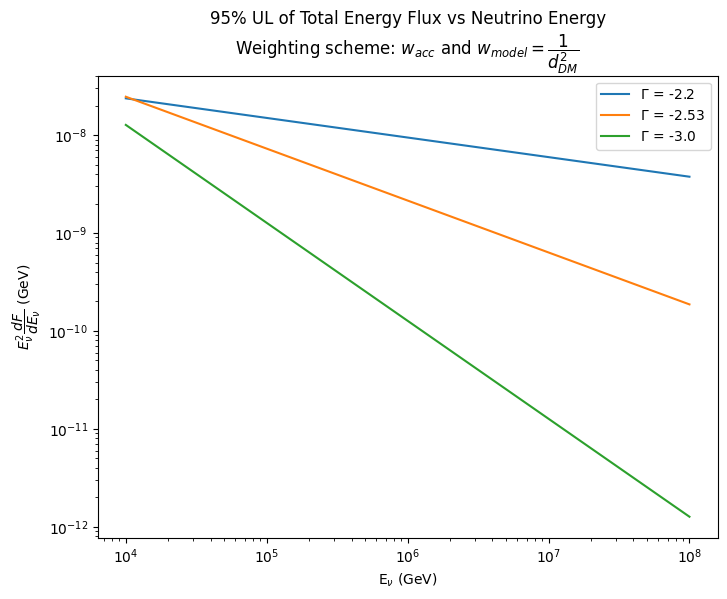

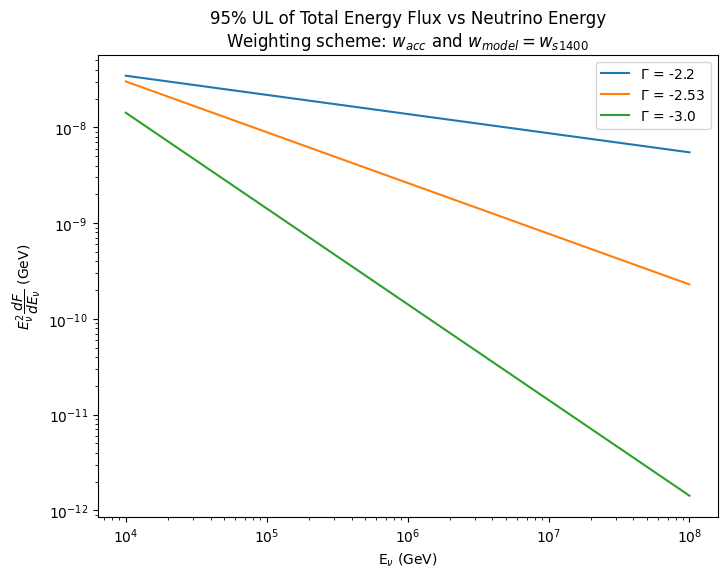

In [47]:

# plt.plot(e_decade, temp, 'o-')
for ws in range(3):
    plt.figure(figsize=(8, 6))
    for gamma in range(1, len(gamma_arr)):
        plt.plot(np.divide(e_decade, 1e9), all_UL[ws][gamma], label=f'$\Gamma$ = {gamma_arr[gamma]}')

    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('E$_{\u03BD}$ (GeV)')
    plt.ylabel("$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ (GeV)")
    plt.title("95% UL of Total Energy Flux vs Neutrino Energy\nWeighting scheme: " + plttitles[ws])
    plt.savefig(f'outputs/UL_{ws}.png', facecolor='white')

In [48]:
np.shape(all_UL)

(3, 4, 5)

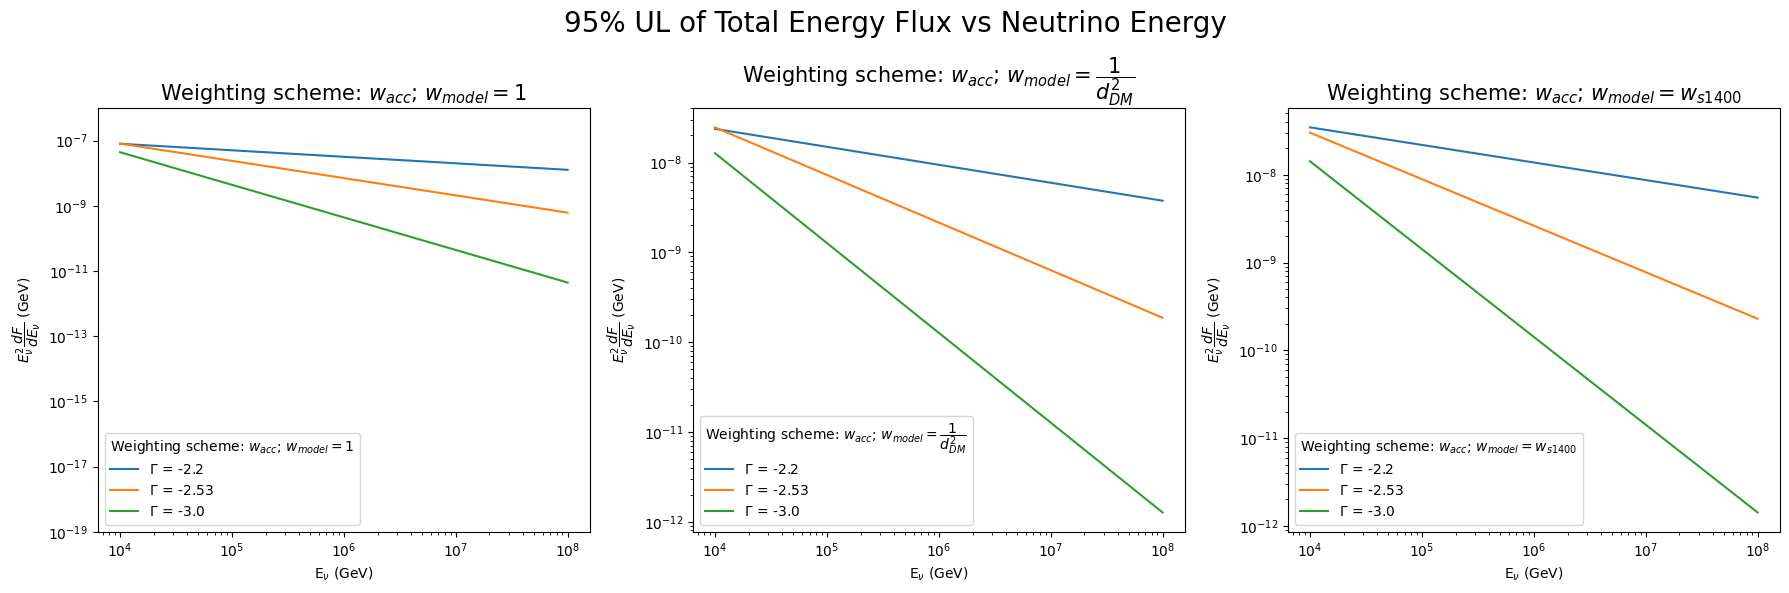

In [49]:
#SIMILAR PLOTS FOR 95% UPPER LIMIT 
fig, axs = plt.subplots(1,3, figsize=(18, 6))

for gamma in range(1, len(gamma_arr)):

    axs[0].plot(np.divide(e_decade, 1e9), all_UL[0][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]))# + ' with wt')    #in GeV

    axs[1].plot(np.divide(e_decade, 1e9), all_UL[1][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]))# + ' with wt and dist')    #in GeV

    axs[2].plot(np.divide(e_decade, 1e9), all_UL[2][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]))# + ' with wt and s1400')    #in GeV

axs[0].set_title('Weighting scheme: $w_{acc}$; $w_{model} = 1$', fontsize=15)
axs[1].set_title('Weighting scheme: $w_{acc}$; $w_{model} = \dfrac{1}{d_{DM}^2}$' , fontsize=15)
axs[2].set_title('Weighting scheme: $w_{acc}$; $w_{model} = w_{s1400}$', fontsize=15)

leg = axs[0].legend(title = 'Weighting scheme: $w_{acc}$; $w_{model} = 1$')
leg._legend_box.align = "left"
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('E$_{\u03BD}$ (GeV)')
axs[0].set_ylabel("$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ (GeV)")
# axs[0].set_title('TS vs $E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$')
axs[0].set_ylim(1e-19, 1e-6)

leg = axs[1].legend(title = 'Weighting scheme: $w_{acc}$; $w_{model} =\dfrac{1}{d_{DM}^2}$')
leg._legend_box.align = "left"
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('E$_{\u03BD}$ (GeV)')
axs[1].set_ylabel("$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ (GeV)")

leg = axs[2].legend(title = 'Weighting scheme: $w_{acc}$; $w_{model} = w_{s1400}$')
leg._legend_box.align = "left"
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel('E$_{\u03BD}$ (GeV)')
axs[2].set_ylabel("$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ (GeV)")

plt.suptitle('95% UL of Total Energy Flux vs Neutrino Energy', fontsize=20)
plt.tight_layout()
plt.savefig(f'outputs/UL_all_w_model_bins={len(enus)}.png')
plt.show()

